In [35]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.3.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [36]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(5):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [37]:
y = data[['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5']]
X = data.drop(columns=['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5'])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
all_results = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(55, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 150
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    #print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")


Test MSE: 0.8157, MAE: 0.4856 R2: 0.9930


In [39]:

def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

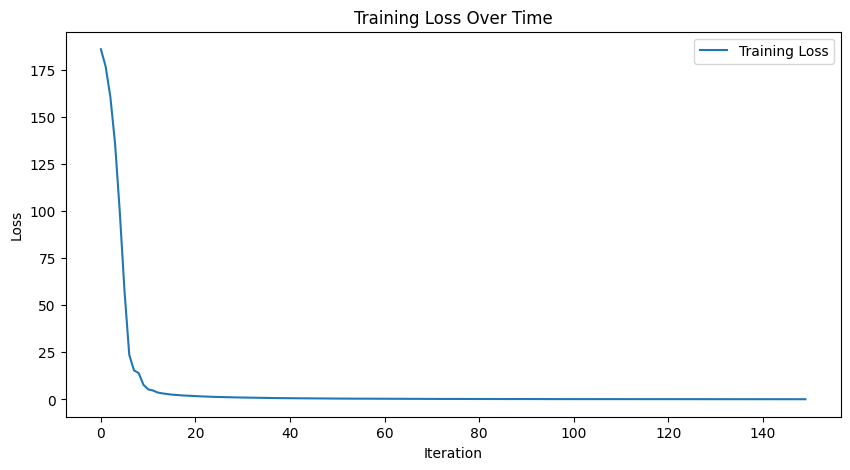

In [40]:
plot_loss()

In [41]:
def plot_compare(tittle):
    target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{target_names[i]}: Actual vs Predicted')
        #ax.set_xlabel('Sample Index')
        ax.set_ylabel(target_names[i])
        ax.grid(True)
        ax.legend()

    fig.suptitle(f'Actual vs Predicted {tittle}', fontsize=16)
    plt.tight_layout()
    plt.show()

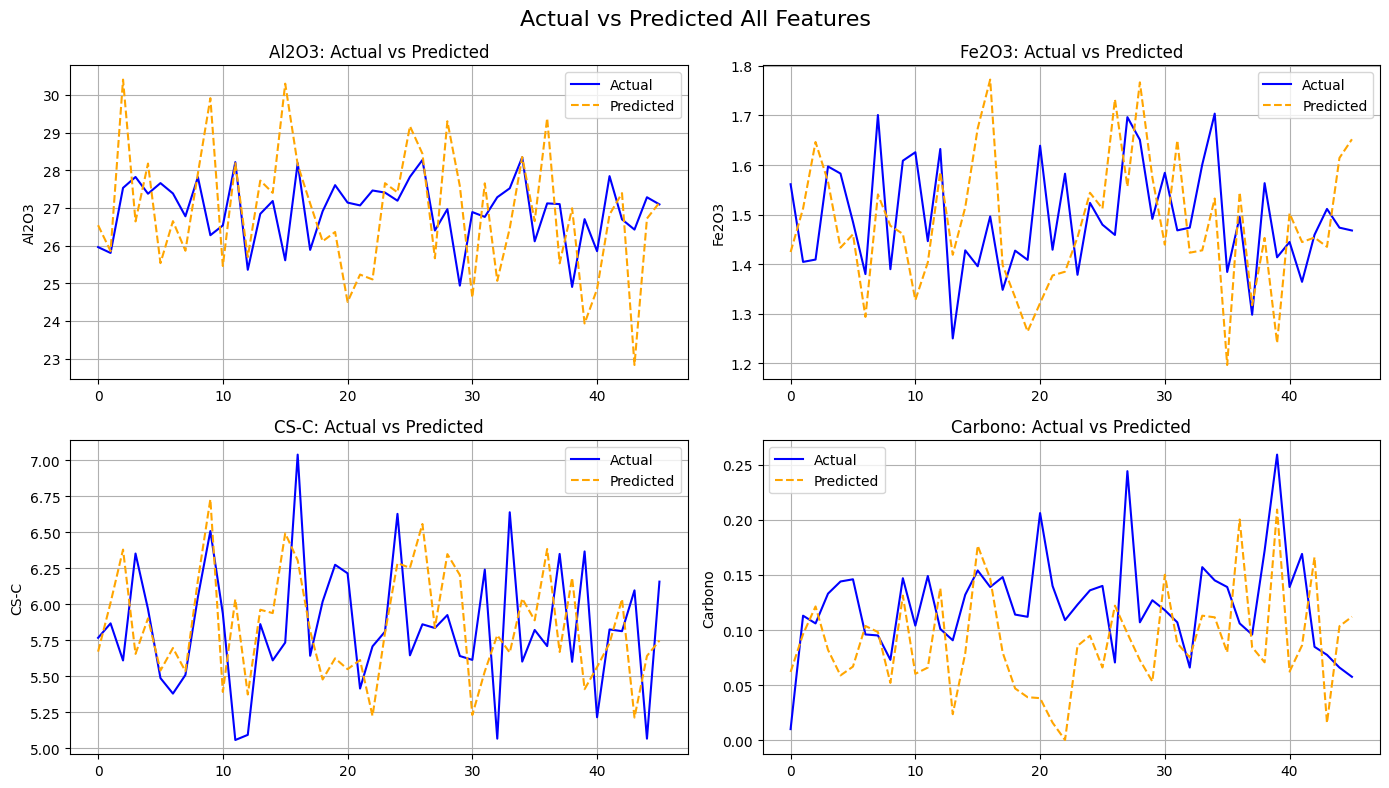

In [42]:
plot_compare('All Features')

In [43]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5, features=''):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))
    results = []
    results.append({
        'Model': features, 
        'MSE': mse,
        'MAE': mae,
        'R2': r2.item()
    })

    return pd.DataFrame(results)

In [44]:

results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features = 'All Features')
all_results.append(results)

Evaluation Results:
 - MSE: 0.8157
 - MAE: 0.4856 
 - R2: 0.9930

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.541847  0.581160
1   1.561302   1.424517 -0.136786
2   5.767001   5.670891 -0.096110
3   0.010200   0.062021  0.051821
4  25.805275  25.853466  0.048191
5   1.404642   1.512377  0.107735
6   5.867491   6.011132  0.143641
7   0.113000   0.096292 -0.016708
8  27.533176  30.408474  2.875298
9   1.409339   1.646510  0.237171


In [45]:
y = data[['Al2O3.5', 'Fe2O3.5','Carbono.5']]
X = data.filter(regex='^Al2O3|^Fe2O3|^Carbono|^%')
X = X.drop(columns=['Al2O3.5', 'Fe2O3.5', 'Carbono.5'])

In [46]:
X.shape, y.shape

((230, 20), (230, 3))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 3), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 3), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 3)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    #print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")


Test MSE: 0.6795, MAE: 0.4301 R2: 0.9955


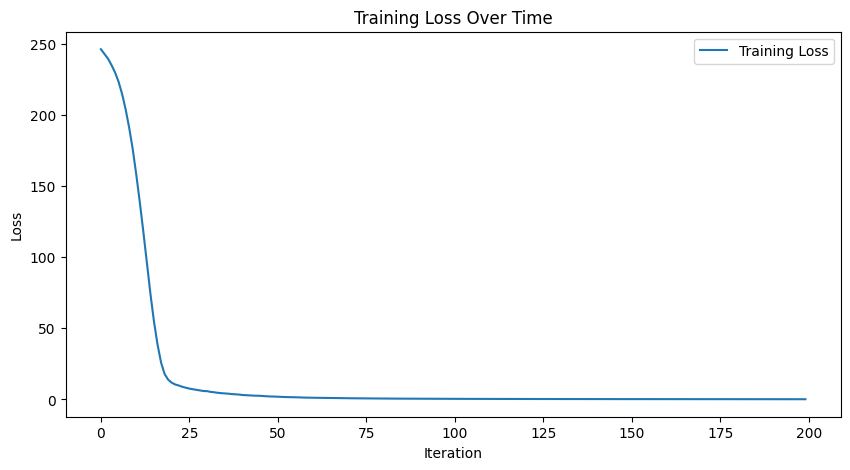

In [48]:
plot_loss()

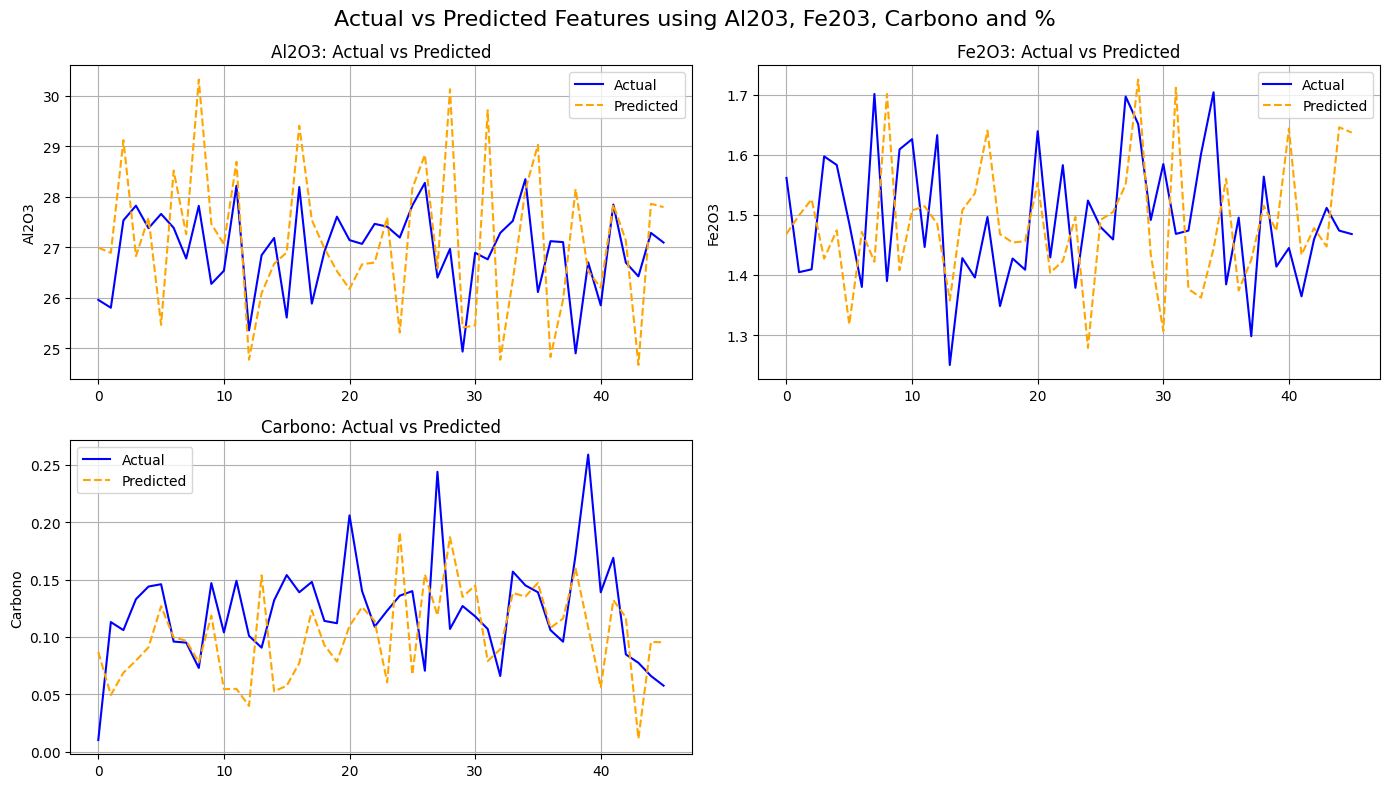

In [49]:
target_names = ['Al2O3', 'Fe2O3','Carbono']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axs.ravel()):
    if i >= len(target_names):
        break
    actual = y_test_tensor[:, i].numpy()
    pred = predictions[:, i].numpy()
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', linestyle='--', color='orange')
    ax.set_title(f'{target_names[i]}: Actual vs Predicted')
    #ax.set_xlabel('Sample Index')
    ax.set_ylabel(target_names[i])
    ax.grid(True)
    ax.legend()

fig.suptitle('Actual vs Predicted Features using Al203, Fe203, Carbono and %', fontsize=16)


for i in range(len(target_names), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

In [53]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203, Fe203, Carbono and %')
all_results.append(results)

Evaluation Results:
 - MSE: 0.6795
 - MAE: 0.4301 
 - R2: 0.9955

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.993868  1.033180
1   1.561302   1.468331 -0.092971
2   0.010200   0.087039  0.076839
3  25.805275  26.889553  1.084278
4   1.404642   1.499058  0.094416
5   0.113000   0.049459 -0.063541
6  27.533176  29.117924  1.584747
7   1.409339   1.525813  0.116474
8   0.106000   0.068856 -0.037144
9  27.822983  26.825617 -0.997366


In [54]:
final_results_df = pd.concat(all_results, ignore_index=True)


print("\nFinal Results:")
from IPython.display import display
display(final_results_df)


Final Results:


,Model,MSE,MAE,R2
0,All Features,0.815669,0.485576,0.993019
1,"Al203, Fe203, Carbono and %",0.679531,0.430052,0.995540


In [55]:
final_results_df = final_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nSorted Final Results:")
display(final_results_df)


Sorted Final Results:


,Model,MSE,MAE,R2
0,"Al203, Fe203, Carbono and %",0.679531,0.430052,0.995540
1,All Features,0.815669,0.485576,0.993019
